In [1]:
# import main libraries
import pandas as pd
import numpy as np

# make pairplots feature vs state
import seaborn as sns
import matplotlib.pyplot as plt

# to evaluate the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import data from csv
df = pd.read_csv('data/kickstarter_projects.csv')

In [2]:
# Explore the data
df.head()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB


ID             0
Name           0
Category       0
Subcategory    0
Country        0
Launched       0
Deadline       0
Goal           0
Pledged        0
Backers        0
State          0
dtype: int64

In [3]:
#write all duplicates to new dataframe
df_duplicates = df[df['Name'].duplicated(keep=False)]
df_duplicates.head (10)

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
524,1896639590,Test (Canceled),Art,Performance Art,United States,2009-09-14 19:37:43,2009-10-14,50,0,0,Canceled
865,2135481078,Canceled (Canceled),Technology,Software,United States,2009-10-25 21:30:47,2009-12-16,2000,0,0,Canceled
982,23113347,Here You Go,Publishing,Publishing,United States,2009-11-10 20:34:29,2009-12-08,2500,3085,96,Successful
1127,488433765,FOUR,Film & Video,Narrative Film,United States,2009-12-01 19:40:40,2010-02-02,18000,19325,181,Successful
1165,210353159,Deleted (Canceled),Photography,Photography,United States,2009-12-07 00:39:05,2010-03-07,5000,0,0,Canceled
1428,77666218,ZERO,Film & Video,Narrative Film,United States,2010-01-12 02:37:42,2010-03-18,5000,155,3,Failed
1715,1617791686,Sympathetic Vibrations,Music,Indie Rock,United States,2010-02-07 01:50:05,2010-04-05,20000,3586,14,Failed
1731,1190237222,Worlds Apart,Journalism,Journalism,United States,2010-02-08 05:03:35,2010-03-03,2000,2325,48,Successful
1818,1976651408,Tent City,Film & Video,Documentary,United States,2010-02-16 00:31:15,2010-05-16,30000,4622,63,Failed
1988,1037569159,Cakestarter,Food,Food,United States,2010-02-27 23:16:22,2010-05-03,7500,7609,163,Successful


In [4]:
# droop 'Backers' and 'Pledged'
df_clean = df.drop(columns=['Backers', 'Pledged', 'ID'])

# convert to datetime
df_clean['Launched'] = pd.to_datetime(df_clean['Launched'])
df_clean['Deadline'] = pd.to_datetime(df_clean['Deadline'])

# duration in days
df_clean['Duration'] = (df_clean['Deadline'] - df_clean['Launched']).dt.days

# statistics for all columns
summary_stats = df_clean.describe(include='all')

# remove rows with "suspended" or "live"
df_clean = df_clean[~df_clean['State'].str.lower().isin(['suspended', 'live', 'canceled'])].copy()

# target variable encoding  
df_clean['State_binary'] = df_clean['State'].apply(lambda x: 1 if x == 'Successful' else 0)

# correlation matrix for numeric features
numeric_features = df_clean.select_dtypes(include=['float64', 'int64'])

# correlation matrix including the target column
correlation_matrix = numeric_features.assign(State=df_clean['State_binary']).corr()

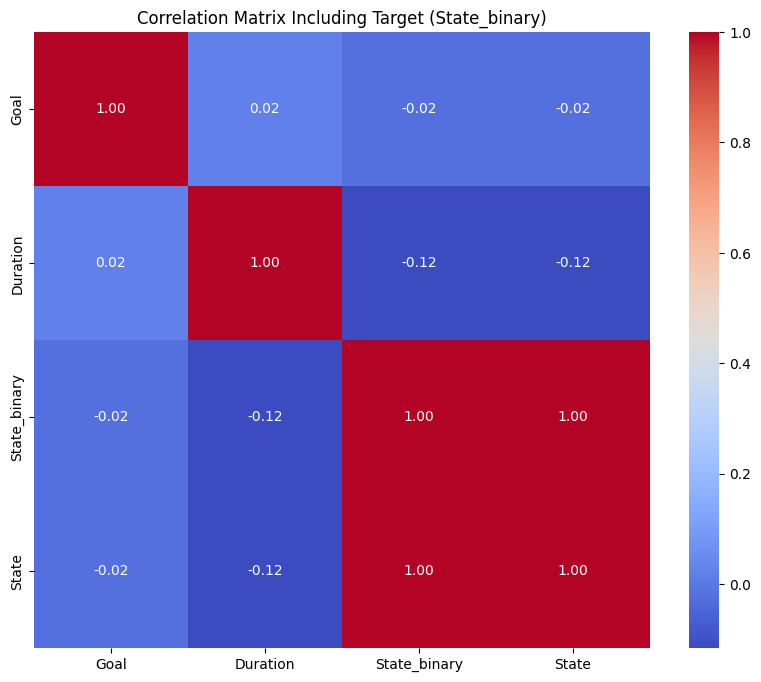

In [5]:
# visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Including Target (State_binary)')
plt.show()

In [6]:
df_clean.head(10)

,Name,Category,Subcategory,Country,Launched,Deadline,Goal,State,Duration,State_binary
0,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,Failed,39,0
1,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,Failed,87,0
2,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,Successful,8,1
3,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,Successful,79,1
4,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,Failed,28,0
5,New York Makes a Book!!,Journalism,Journalism,United States,2009-04-28 13:55:41,2009-05-16,3000,Successful,17,1
6,Web Site for Short Horror Film,Film & Video,Shorts,United States,2009-04-29 02:04:21,2009-05-29,200,Failed,29,0
7,Help me write my second novel.,Publishing,Fiction,United States,2009-04-29 02:58:50,2009-05-29,500,Successful,29,1
9,Sponsor Dereck Blackburn (Lostwars) Artist in ...,Music,Rock,United States,2009-04-29 05:26:32,2009-05-16,300,Failed,16,0
10,kicey to iceland,Photography,Photography,United States,2009-04-29 06:43:44,2009-06-17,350,Successful,48,1


In [7]:
# one-hot-encoding 
df_model = pd.get_dummies(df_clean, columns=['Category', 'Country', 'Subcategory'], drop_first=True)

In [8]:
df_model.head(10)

,Name,Launched,Deadline,Goal,State,Duration,State_binary,Category_Comics,Category_Crafts,Category_Dance,...,Subcategory_Wearables,Subcategory_Weaving,Subcategory_Web,Subcategory_Webcomics,Subcategory_Webseries,Subcategory_Woodworking,Subcategory_Workshops,Subcategory_World Music,Subcategory_Young Adult,Subcategory_Zines
0,Grace Jones Does Not Give A F$#% T-Shirt (limi...,2009-04-21 21:02:48,2009-05-31,1000,Failed,39,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,CRYSTAL ANTLERS UNTITLED MOVIE,2009-04-23 00:07:53,2009-07-20,80000,Failed,87,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,drawing for dollars,2009-04-24 21:52:03,2009-05-03,20,Successful,8,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Offline Wikipedia iPhone app,2009-04-25 17:36:21,2009-07-14,99,Successful,79,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Pantshirts,2009-04-27 14:10:39,2009-05-26,1900,Failed,28,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,New York Makes a Book!!,2009-04-28 13:55:41,2009-05-16,3000,Successful,17,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,Web Site for Short Horror Film,2009-04-29 02:04:21,2009-05-29,200,Failed,29,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,Help me write my second novel.,2009-04-29 02:58:50,2009-05-29,500,Successful,29,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,Sponsor Dereck Blackburn (Lostwars) Artist in ...,2009-04-29 05:26:32,2009-05-16,300,Failed,16,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,kicey to iceland,2009-04-29 06:43:44,2009-06-17,350,Successful,48,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score, f1_score
import pandas as pd

# more features 
df_model = df_model.copy()
df_model['Name_length'] = df_clean['Name'].str.len()
df_model['Word_count'] = df_clean['Name'].str.split().apply(len)
df_model['Has_number'] = df_clean['Name'].str.contains(r'\d').astype(int)
df_model['Has_exclamation'] = df_clean['Name'].str.contains('!').astype(int)
df_model['Launch_month'] = df_clean['Launched'].dt.month
df_model = pd.get_dummies(df_model, columns=['Launch_month'], drop_first=True)

# feature selection and target variable 
X = df_model.drop(columns=['State', 'Launched', 'Deadline', 'Name', 'State_binary'])
y = df_model['State_binary']

# Only keep numeric features for the model 
X = X.select_dtypes(include=['number'])

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# =======================
# Random Forest Model
# =======================
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("RANDOM FOREST")
print("F1 Score (Class 1):", f1_score(y_test, y_pred_rf, pos_label=1))
print("Precision (Class 1):", precision_score(y_test, y_pred_rf, pos_label=1))
print(classification_report(y_test, y_pred_rf))

# =======================
# XGBoost Model
# =======================
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # class imbalance handling 
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBOOST")
print("F1 Score (Class 1):", f1_score(y_test, y_pred_xgb, pos_label=1))
print("Precision (Class 1):", precision_score(y_test, y_pred_xgb, pos_label=1))
print(classification_report(y_test, y_pred_xgb))

RANDOM FOREST
F1 Score (Class 1): 0.5846664098226102
Precision (Class 1): 0.5299887637037262
              precision    recall  f1-score   support

           0       0.72      0.61      0.66     39523
           1       0.53      0.65      0.58     26770

    accuracy                           0.63     66293
   macro avg       0.63      0.63      0.62     66293
weighted avg       0.64      0.63      0.63     66293


XGBOOST
F1 Score (Class 1): 0.5900287183597142
Precision (Class 1): 0.5334520862266772
              precision    recall  f1-score   support

           0       0.73      0.61      0.66     39523
           1       0.53      0.66      0.59     26770

    accuracy                           0.63     66293
   macro avg       0.63      0.63      0.63     66293
weighted avg       0.65      0.63      0.63     66293



In [11]:
# feature importance for Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# get feature importance 
importances = rf.feature_importances_
feature_names = X_train.columns
important_features = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Top 20 Features
print(important_features.head(20))



Goal               0.489234
Name_length        0.251783
Duration           0.167254
Word_count         0.075309
Has_exclamation    0.008782
Has_number         0.007639
dtype: float64


In [12]:
from sklearn.feature_selection import SelectFromModel
# Select features based on importance from Random Forest
selector = SelectFromModel(rf, threshold="median", prefit=True)
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)
# check the shape of the reduced dataset
print("Original shape:", X_train.shape)
# get random forest with reduced features
rf_model_reduced = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight='balanced',
    random_state=42
)
rf_model_reduced.fit(X_train_reduced, y_train)  

c:\Users\thear\Neue Fische c\kickstart_ml\.venv\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\thear\Neue Fische c\kickstart_ml\.venv\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Original shape: (265169, 6)


RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                       random_state=42)

In [13]:
y_pred_rf_reduced = rf_model_reduced.predict(X_test_reduced)

print("RANDOM FOREST")
print("F1 Score (Class 1):", f1_score(y_test, y_pred_rf_reduced, pos_label=1))
print("Precision (Class 1):", precision_score(y_test, y_pred_rf_reduced, pos_label=1))
print(classification_report(y_test, y_pred_rf_reduced))

RANDOM FOREST
F1 Score (Class 1): 0.5783386967015286
Precision (Class 1): 0.5245029488660546
              precision    recall  f1-score   support

           0       0.72      0.60      0.66     39523
           1       0.52      0.64      0.58     26770

    accuracy                           0.62     66293
   macro avg       0.62      0.62      0.62     66293
weighted avg       0.64      0.62      0.62     66293



In [14]:
xgb_model_reduced = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # class imbalance handling 
    random_state=42
)
xgb_model_reduced.fit(X_train_reduced, y_train)
y_pred_xgb_reduced = xgb_model_reduced.predict(X_test_reduced)

print("\nXGBOOST")
print("F1 Score (Class 1):", f1_score(y_test, y_pred_xgb_reduced, pos_label=1))
print("Precision (Class 1):", precision_score(y_test, y_pred_xgb_reduced, pos_label=1))
print(classification_report(y_test, y_pred_xgb_reduced))


XGBOOST
F1 Score (Class 1): 0.5871781693993601
Precision (Class 1): 0.5278547795761424
              precision    recall  f1-score   support

           0       0.72      0.60      0.66     39523
           1       0.53      0.66      0.59     26770

    accuracy                           0.62     66293
   macro avg       0.63      0.63      0.62     66293
weighted avg       0.64      0.62      0.63     66293



In [15]:
from sklearn.model_selection import GridSearchCV

# class imbalance handling
# calculate scale_pos_weight for XGBoost
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

# parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, scale_weight]
}

# Model
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# GridSearchCV
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
# Fit the model with the training data
grid.fit(X_train, y_train)

# best parameters and score
print("Best parameters:", grid.best_params_)
print("Best F1 score (CV):", grid.best_score_)

# test the best model on the test set 
best_xgb = grid.best_estimator_
y_pred_best = best_xgb.predict(X_test)

print("F1 Score (Test, Klasse 1):", f1_score(y_test, y_pred_best, pos_label=1))
print("Precision (Test, Klasse 1):", precision_score(y_test, y_pred_best, pos_label=1))
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1.4763403404899096, 'subsample': 1.0}
Best F1 score (CV): 0.5941129019495875
F1 Score (Test, Klasse 1): 0.5911500307405992
Precision (Test, Klasse 1): 0.5323995091436952
              precision    recall  f1-score   support

           0       0.73      0.60      0.66     39523
           1       0.53      0.66      0.59     26770

    accuracy                           0.63     66293
   macro avg       0.63      0.63      0.63     66293
weighted avg       0.65      0.63      0.63     66293



In [16]:
# class imbalance handling
# calculate scale_pos_weight for XGBoost
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

# parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, scale_weight]
}

# Model
xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# GridSearchCV
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)
# Fit the model with the training data
grid.fit(X_train_reduced, y_train)

# best parameters and score
print("Best parameters:", grid.best_params_)
print("Best F1 score (CV):", grid.best_score_)

# test the best model on the test set 
best_xgb = grid.best_estimator_
y_pred_best = best_xgb.predict(X_test_reduced)

from sklearn.metrics import f1_score, precision_score, classification_report
print("F1 Score (Test, Klasse 1):", f1_score(y_test, y_pred_best, pos_label=1))
print("Precision (Test, Klasse 1):", precision_score(y_test, y_pred_best, pos_label=1))
print(classification_report(y_test, y_pred_best))

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 1.4763403404899096, 'subsample': 1.0}
Best F1 score (CV): 0.5892841973825073
F1 Score (Test, Klasse 1): 0.588560946047761
Precision (Test, Klasse 1): 0.5240637031851593
              precision    recall  f1-score   support

           0       0.72      0.59      0.65     39523
           1       0.52      0.67      0.59     26770

    accuracy                           0.62     66293
   macro avg       0.62      0.63      0.62     66293
weighted avg       0.64      0.62      0.62     66293



### More feature engeniering


In [17]:
# log transformation for 'Goal' 
df_clean['Log_Goal'] = np.log1p(df_clean['Goal'])  # log(Goal + 1), um 0 zu vermeiden

# weekday extraction from 'Launched'
df_clean['Launch_weekday'] = df_clean['Launched'].dt.weekday

# optional: One-Hot-Encoding for 'Launch_weekday'
df_clean = pd.get_dummies(df_clean, columns=['Launch_weekday'], drop_first=True)

# combine 'Category' and 'Subcategory' into a new feature
df_clean['Category_Combo'] = df_clean['Category'] + "_" + df_clean['Subcategory']

# optional: One-Hot-Encoding for 'Category_Combo'
df_clean = pd.get_dummies(df_clean, columns=['Category_Combo'], drop_first=True)

### Pipeline and functions

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def train_and_evaluate_models(X_train, X_test, y_train, y_test, scale=False, use_feature_selection=False):
    results = {}
    
    # optional scaling
    scaler = StandardScaler() if scale else 'passthrough'
    
    # =======================
    # Random Forest Pipeline
    # =======================
    rf_base = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        class_weight='balanced',
        random_state=42
    )
    
    # optional feature selection
    rf_selector = SelectFromModel(rf_base) if use_feature_selection else 'passthrough'

    rf_pipeline = Pipeline([
        ('scaler', scaler),
        ('feature_select', rf_selector),
        ('classifier', rf_base)
    ])
    
    rf_pipeline.fit(X_train, y_train)
    y_pred_rf = rf_pipeline.predict(X_test)

    print("=== RANDOM FOREST ===")
    print("F1 Score (Class 1):", f1_score(y_test, y_pred_rf, pos_label=1))
    print("Precision (Class 1):", precision_score(y_test, y_pred_rf, pos_label=1))
    print(classification_report(y_test, y_pred_rf))
    
    results['random_forest'] = {
        'model': rf_pipeline,
        'y_pred': y_pred_rf
    }
    
    # =======================
    # XGBoost Pipeline
    # =======================
    xgb_base = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        random_state=42
    )

    xgb_selector = SelectFromModel(xgb_base) if use_feature_selection else 'passthrough'

    xgb_pipeline = Pipeline([
        ('scaler', scaler),
        ('feature_select', xgb_selector),
        ('classifier', xgb_base)
    ])

    xgb_pipeline.fit(X_train, y_train)
    y_pred_xgb = xgb_pipeline.predict(X_test)

    print("=== XGBOOST ===")
    print("F1 Score (Class 1):", f1_score(y_test, y_pred_xgb, pos_label=1))
    print("Precision (Class 1):", precision_score(y_test, y_pred_xgb, pos_label=1))
    print(classification_report(y_test, y_pred_xgb))
    
    results['xgboost'] = {
        'model': xgb_pipeline,
        'y_pred': y_pred_xgb
    }
    
    return results

In [19]:
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, scale=True, use_feature_selection=True)

=== RANDOM FOREST ===
F1 Score (Class 1): 0.5809411878350749
Precision (Class 1): 0.5104829810712164
              precision    recall  f1-score   support

           0       0.72      0.56      0.63     39523
           1       0.51      0.67      0.58     26770

    accuracy                           0.61     66293
   macro avg       0.61      0.62      0.61     66293
weighted avg       0.63      0.61      0.61     66293

=== XGBOOST ===
F1 Score (Class 1): 0.5893528596873144
Precision (Class 1): 0.5276088111970708
              precision    recall  f1-score   support

           0       0.73      0.60      0.65     39523
           1       0.53      0.67      0.59     26770

    accuracy                           0.62     66293
   macro avg       0.63      0.63      0.62     66293
weighted avg       0.65      0.62      0.63     66293

